# 深度探索监督学习：决策树、随机森林

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

之前我们已经了解过了强大的判别分类器，**支持向量机**。在这里我们要看一看另一种强大的算法。这个算法是一个*非参数*方法，叫**随机森林**。
GBDT xgboost

## 随机森林：决策树

随机森林是在决策树的基础上的一个*集成学习*算法。所以我们从讨论决策树开始我们的介绍，

决策树是一个非常直观的，给对象分类或者是贴标签的方法：您仅仅需要提出一系列的问题并回答它们，模型会根据问题的答案逐渐完善。

- a)线性分类器对于特征与类别之间的关系是“线性假设”，如果遇到非线性的关系，就很难辨识，比如Titanic数据中，如果假设“年龄”与“生存”是正相关的，那么年龄越大，越有可能生存；但是事实证明，这个假设是错误的，不是正相关，而偏偏是老人与小孩更加容易获得生存的机会。这种情况，线性假设不完全成立，因此，需要**非线性的分类器**。

- b)即便使用类似SVM的分类器，我们很难得到明确分类“依据”的说明，**无法“解释”**分类器是如何工作的，特别无法从人类逻辑的角度理解。高维度、不可解释性等，这些都是弊端。

  决策树分类器解决了上述两点问题。

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


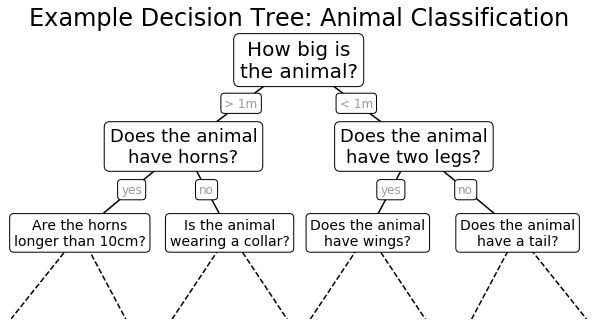

In [2]:
import fig_code
fig_code.plot_example_decision_tree()

对所有问题，仅需要回答"是"或者"否"，这让分类变得极其有效。但是，这里需要注意的是，我们需要*问应该问的问题*。在训练一个决策树分类器时，算法会根据问题的特征去找出哪一个问题包含着最多的信息。

### 创建一个决策树

这儿是一个在sklearn中决策树的例子。我们会以定义一组二维的有标签的数据开始：

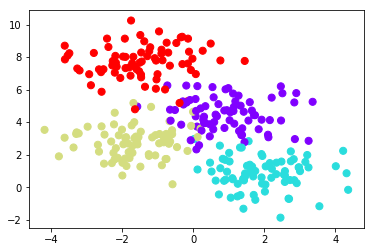

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

我们在sklearn的库中有一些可以提供帮助的函数：

In [4]:
from fig_code import visualize_tree, plot_tree_interactive

现在使用 IPython 的``interact`` (在 IPython2.0+ 中可以使用，且需要一个实时的核)。我们可以看到决策树的分隔:

In [5]:
plot_tree_interactive(X, y);

C:\ProgramData\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


interactive(children=(Dropdown(description='depth', options=(1, 5), value=1), Output()), _dom_classes=('widget…

注意到随着深度的增加，**除了**那些本来只包含一类的点之外，每一个数据集都被成功的划分。
这是个非常快的**无参数**分类过程，在实际运用中非常实用。

**问题：您看到这里隐含的缺陷了吗？**

### 决策树和过拟合

决策树的一个特点就是，它训练出来的模型非常容易产生**过拟合**。也就是说，模型的弹性非常大，以至于它们对数据的噪声的学习可以高过数据本身！比如，接下来我们可以看一看两种决策树模型，针对同一个数据集的两个子集的建模情况：

<Figure size 432x288 with 0 Axes>

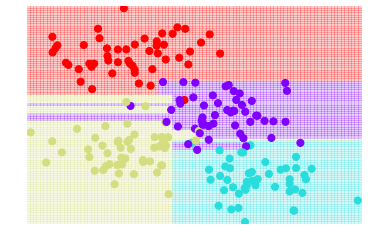

<Figure size 432x288 with 0 Axes>

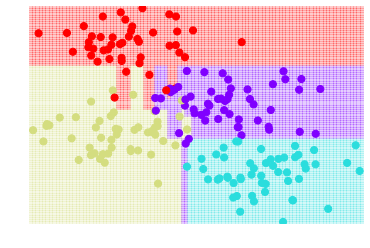

In [6]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

plt.figure()
visualize_tree(clf, X[:200], y[:200], boundaries=False)
plt.figure()
visualize_tree(clf, X[-200:], y[-200:], boundaries=False)

两种分类模型的细节完全不一样！这就是**过拟合**的一个直观展示：当你采用你的模型去预测一个新的点的时候，这个模型更容易被数据中的噪声而不是数据本身所影响。

## 集成学习Estimators：随机森林

一个可能的解决过拟合问题的方式是采用**集成方法**：创建一个总的estimator，它对很多的独立的，容易产生过拟合的estimator取了平均。让人有些惊讶的是，这个总的estimator的效果非常好，它比任何一个组成它的独立的estimator都要稳定和精确！

**随机森林**就是众多集成方法中的一种，这里，集成的意思是总的estimator会由很多决策树组成。

对于如何随机组合这些决策树，现在有很多方法和原理。但是，举个例子，我们来看一组estimator对于数据的不同子集建模的结果。我们可以通过接下来的内容获得更好的理解：

In [7]:
def fit_randomized_tree(random_state=0):
    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=2.0)
    clf = DecisionTreeClassifier(max_depth=15)
    
    rng = np.random.RandomState(random_state)#产生随机数
    i = np.arange(len(y))
    rng.shuffle(i)  #在原数组上随机打乱进行，改变自身序列，无返回值， 相当于随机选择250个数据进行训练
    visualize_tree(clf, X[i[:250]], y[i[:250]], boundaries=False,
                   xlim=(X[:, 0].min(), X[:, 0].max()),
                   ylim=(X[:, 1].min(), X[:, 1].max()))
    
from IPython.html.widgets import interact
interact(fit_randomized_tree, random_state=[0, 100]);

interactive(children=(Dropdown(description='random_state', options=(0, 100), value=0), Output()), _dom_classes…

我们可以看到，不管细节怎么随着函数的改变而改变，大的特征总是保持不变的！随机森林的分类器会做类似的事情，只是它会把所有的模型组合起来去得到最后的结果：

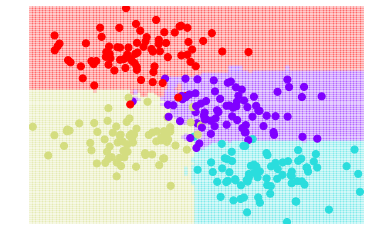

In [8]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, random_state=0)
visualize_tree(clf, X, y, boundaries=False);


随机森林顾名思义，是用随机的方式建立一个森林，森林里面有很多的决策树组成，随机森林的每一棵决策树之间是没有关联的。在得到森林之后，当有一个新的输 入样本进入的时候，就让森林中的每一棵决策树分别进行一下判断，看看这个样本应该属于哪一类（对于分类算法），然后看看哪一类被选择最多，就预测这个样本 为那一类。

*(注意: 上面我们通过下采样的方式对我们的模型做了随机。随机森林运用了更加成熟的方法，对于这点您可以参考 [scikit-learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest)*)

## 例子：运用随机森林算法做数字分类

我们之前已经接触了**手写数字**的数据集。我们现在来对支持向量机分类器和随机森林分类器在数据集上的效率做一些评估。

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [10]:
X = digits.data
y = digits.target
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


为了让我们更好的记起来手写数字数据集，我们先将其中一部分画出来：

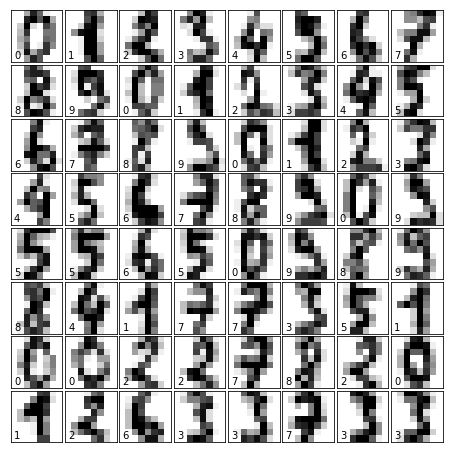

In [11]:
# 设置绘图
fig = plt.figure(figsize=(6, 6))  # 图片大小是以英寸(inches)计算的
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# 绘制这些数字: 每个图像是 8x8 像素点阵的
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # 每一个图像做上对应的标记(label，就是target值)
    ax.text(0, 7, str(digits.target[i]))

我们可以使用决策树来快速的对数字进行分类：

class sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)

**max_depth**:决策树最大深度。默认值是‘None’。（int,  None）
一般数据比较少或者特征少的时候可以不用管这个值，如果模型样本数量多，特征也多时，推荐限制这个最大深度,具体取值取决于数据的分布。常用的可以取值10-100之间，常用来解决过拟合。
                     
**max_features**:在划分数据集时考虑的最多的特征值数量。
         int值，在每次split时最大特征数；float值表示百分数，即（max_features*n_features）;
更多参数请参考文档

In [12]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)#random_state确定随机数的序列
# random_state设定一个值，每次划分可以都一样
clf = DecisionTreeClassifier(max_depth=11,max_features=0.5) #决策树
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

我们可以检查一下这个分类器的准确率：

In [13]:
metrics.accuracy_score(ypred, ytest)

0.8177777777777778

In [14]:
metrics.f1_score(ypred, ytest,average='macro')

0.821197928563568

为了更好的看出分类器的性能，我们画出混淆矩阵：

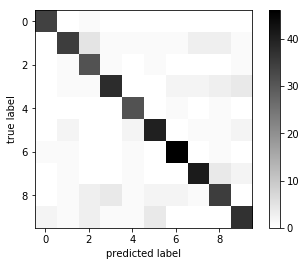

In [15]:
plt.imshow(metrics.confusion_matrix(ypred, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label");

### 练习
1. 用``sklearn.ensemble.RandomForestClassifier``在做一次分类任务。并回答``max_depth``，``max_features``和``n_estimators``是如何影响结果的？
2. 用``sklearn.svm.SVC``来做分类，调整``kernel``,``C``和``gamma``。哪一个分类器效果最好？
3. 针对每个模型尝试着用不同的参数去跑，查看结果的F1分数(``sklearn.metrics.f1_score``)。您能达到的最高的F1分数是什么？

In [ ]:
RandomForestClassifier?

class sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)

- n_estimators : 森林里决策树个数，默认10
- max_features ：寻找最佳分割时需要考虑的特征数目，小数的话作为百分比*总特征数目
- max_depth ： 树最大深度

In [16]:
#小练习  尝试用 随机森林 做上面的分类  sklearn.ensemble.RandomForestClassifier  
#clf = RandomForestClassifier(max_depth=10,max_features=10,n_estimators=150)

from sklearn.ensemble import RandomForestClassifier
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
clf = RandomForestClassifier(max_depth=11,n_estimators=150) #随机森林
clf.fit(Xtrain, ytrain) 
ypred = clf.predict(Xtest)


In [17]:
metrics.accuracy_score(ypred, ytest)

0.9822222222222222

In [18]:
metrics.f1_score(ypred, ytest,average='macro')

0.982201725188465

## 回归问题

回归问题和分类问题都同属于监督学习范畴，唯一不同的是，回归问题的预测目标是在无限的连续实数域，比如预测房价、股票价格等等；分类问题则是对有限范围的几个类别（离散数）进行预测。

我们在之前对随机森林的讨论都是基于分类问题的。
随机森林也可以被用在回归问题中(也就是，预测的是连续而不是离散的值)。对应的estimator是``sklearn.ensemble.RandomForestRegressor``.

我们快速的看一下它是如何使用的：

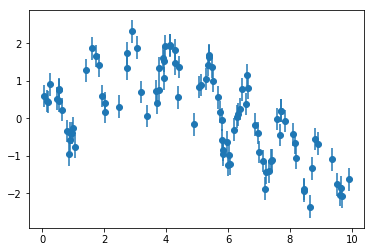

In [19]:
from sklearn.ensemble import RandomForestRegressor

x = 10 * np.random.rand(100)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * np.random.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

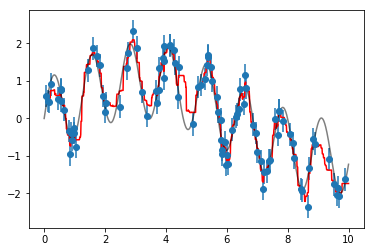

In [20]:
xfit = np.linspace(0, 10, 1000)
yfit = RandomForestRegressor(100).fit(x[:, None], y).predict(xfit[:, None]) #numpy.newaxis效果和None是一样的，None是它的别名
ytrue = model(xfit, 0)

plt.errorbar(x, y, 0.3, fmt='o')
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

从中你可以看到，这个非参数的**随机森林的模型足够去拟合多周期的数据**，甚至都不需要我们为它指定一个多周期的模型！

## 回归分析：预测美国波士顿地区房价

In [21]:
# 首先预读房价数据
from sklearn.datasets import load_boston

boston = load_boston()

# 查验数据规模
boston.data.shape

(506, 13)

In [22]:
# 弄懂数据特征的含义也是一个好习惯
print(boston.feature_names)
print(boston.DESCR)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial hig

In [23]:
# 这里多一个步骤，查验数据是否正规化，一般都是没有的
import numpy as np

print(np.max(boston.target))
print( np.min(boston.target))
print( np.mean(boston.target))

50.0
5.0
22.532806324110677


In [25]:
from sklearn.model_selection import train_test_split
# 依然如故，我们对数据进行分割
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size = 0.25, random_state=33)

from sklearn.preprocessing import StandardScaler

# 正规化的目的在于避免原始特征值差异过大，导致训练得到的参数权重不一
scalerX = StandardScaler().fit(X_train)
X_train = scalerX.transform(X_train)

X_test = scalerX.transform(X_test)# 测试集  要和训练集一样 做相同的预处理

# scalery = StandardScaler().fit(y_train)
# y_train = scalery.transform(y_train)
# y_test = scalery.transform(y_test)

In [26]:
X_train[0] 

array([-0.32076092,  0.35553428, -1.00966618, -0.28784917,  0.87716097,
        1.28834383,  0.4759489 , -0.83034371, -0.47659648, -0.81061061,
       -2.49222645,  0.35062335, -0.39859013])

In [28]:
# 先把评价模块写好，依然是默认5折交叉验证，
#只是这里的评价指标不再是精度，而是另一个函数R2，
#大体上，这个得分多少代表有多大百分比的回归结果可以被训练器覆盖和解释
from sklearn.model_selection import *

def train_and_evaluate(clf, X_train, y_train):
    cv = KFold(n_splits=5, shuffle=True, random_state=33)
    scores = cross_val_score(clf, X_train, y_train, cv=cv)
    print( 'Average coefficient of determination using 5-fold cross validation:', np.mean(scores))
    
#最后让我们看看有多少种回归模型可以被使用（其实有更多）。
# 比较有代表性的有3种

In [29]:
# 先用线性模型尝试， SGD_Regressor   性能好，适合大规模数据
from sklearn import linear_model
# 这里有一个正则化的选项penalty，目前14维特征也许不会有太大影响
clf_sgd = linear_model.SGDRegressor(loss='squared_loss', penalty=None, random_state=42)
train_and_evaluate(clf_sgd, X_train, y_train)

Average coefficient of determination using 5-fold cross validation: 0.7130664262321351


In [30]:
# 再换一个SGD_Regressor的penalty参数为l2,结果貌似影响不大，因为特征太少，正则化意义不大
# L1正则化和L2正则化作用：
# L1正则化可以产生稀疏权值矩阵，即产生一个稀疏模型，可以用于特征选择。
# L2正则化可以防止模型过拟合（overfitting），一定程度上，L1也可以防止过拟合。
clf_sgd_l2 = linear_model.SGDRegressor(loss='squared_loss', penalty='l2', random_state=42)
train_and_evaluate(clf_sgd_l2, X_train, y_train)

Average coefficient of determination using 5-fold cross validation: 0.7130763342624213


In [31]:
# 再看看SVM的regressor怎么样（都是默认参数）, 
from sklearn.svm import SVR
# 使用线性核没有啥子提升，但是因为特征少，所以可以考虑升高维度
clf_svr = SVR(C=100,kernel='linear')  
train_and_evaluate(clf_svr, X_train, y_train)

Average coefficient of determination using 5-fold cross validation: 0.7010251931138348


In [32]:
clf_svr_rbf = SVR(C=100,kernel='rbf') 
# RBF (径向基核)
train_and_evaluate(clf_svr_rbf, X_train, y_train)

# 最后看看在测试集上的表现
clf_svr_rbf.fit(X_train, y_train)   #训练集
clf_svr_rbf.score(X_test, y_test)   #测试集

Average coefficient of determination using 5-fold cross validation: 0.8885225923920211


0.7836859528453155

In [33]:
# 随机森林
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
clf_et = RandomForestRegressor(max_depth=10,max_features=6,n_estimators=150)  
train_and_evaluate(clf_et, X_train, y_train)

clf_et.fit(X_train, y_train)
clf_et.score(X_test, y_test)

Average coefficient of determination using 5-fold cross validation: 0.849116129994148


0.8471782149648237